In [6]:
from invisible_cities.cities.components import wf_from_files, WfType
from invisible_cities.cities.components import deconv_pmt, calibrate_pmts, get_pmt_wfs, load_dst
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tables as tb
import os
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap
from mpl_interactions import ioff, panhandler, zoom_factory

In [2]:
file_list = os.listdir("../data/DEMO/kdst/")

evt_filter_kdst = []
kdst_dfs = []

for file in file_list:

    path = "../data/DEMO/kdst/" + file
    kdst = pd.read_hdf(path, "/DST/Events")
    kdst = kdst[kdst.nS1 == 1]
    kdst = kdst[kdst.nS2 == 1]
    # kdst = kdst[kdst.Z < 25]
    kdst = kdst[  np.sqrt(kdst.X*kdst.X + kdst.Y*kdst.Y) < 60]

    # This removes events where the zrms is not consistent with the z value
    kdst = kdst[ (kdst.Zrms > 0.0035*kdst.Z+0.6) & (kdst.Zrms < 0.0035*kdst.Z+1)  ]

    # display(kdst)

    evt_filter_kdst.append(kdst.event.unique())
    kdst_dfs.append(kdst)

evt_filter_kdst = np.concatenate(evt_filter_kdst, axis=0)
kdst_dfs = pd.concat(kdst_dfs)
print(evt_filter_kdst)
display(kdst_dfs)

[ 8314  8326  8351 ... 19338 19341 19346]


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
69,8314,1.686317e+09,0,0,1,1,125.0,1.345299,5.819739,229525.0,...,86,174.951355,174.951355,1.491537,-18.739323,7.670549,20.248446,2.753070,20.899015,23.056147
124,8326,1.686317e+09,0,0,1,1,150.0,1.643902,7.698569,254775.0,...,65,148.713913,148.713913,1.376443,46.224703,23.631799,51.915172,0.472597,24.204749,18.702169
173,8351,1.686317e+09,0,0,1,1,125.0,1.354941,5.873026,158750.0,...,65,245.739731,245.739731,1.665869,25.533415,42.424686,49.515748,1.029016,18.606528,21.173653
212,8365,1.686317e+09,0,0,1,1,125.0,2.735059,8.831255,230725.0,...,78,173.738220,173.738220,1.485563,14.434207,0.879190,14.460958,0.060835,21.548278,20.697165
218,8369,1.686317e+09,0,0,1,1,175.0,2.373553,10.791920,266750.0,...,79,136.739944,136.739944,1.405988,-20.778597,-19.644295,28.594553,-2.384248,20.958342,20.787122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7223,19313,1.686318e+09,0,0,1,1,175.0,1.561092,9.493186,106450.0,...,81,298.031128,298.031128,1.880435,10.253619,3.800023,10.935121,0.354910,20.828019,20.615298
7236,19316,1.686318e+09,0,0,1,1,150.0,1.798229,7.713978,103475.0,...,77,301.025879,301.025879,1.923363,33.003075,7.972845,33.952455,0.237037,24.692810,20.735372
7307,19338,1.686318e+09,0,0,1,1,175.0,1.321501,6.727635,234975.0,...,84,168.534546,168.534546,1.463420,-4.835905,-19.919976,20.498571,-1.808956,24.177238,27.269983
7314,19341,1.686318e+09,0,0,1,1,175.0,2.179503,8.944860,140825.0,...,61,263.666107,263.666107,1.823012,45.462923,-10.302102,46.615563,-0.222841,17.282948,19.870911


(0.0, 400.0)

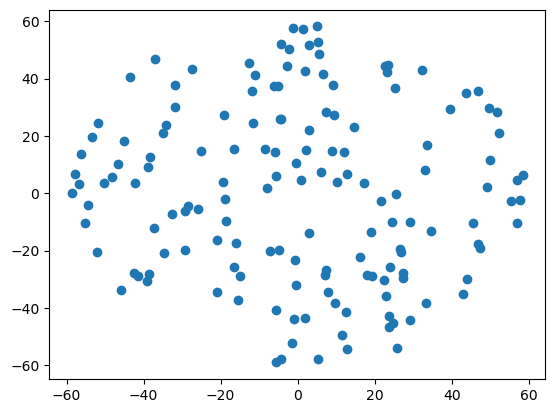

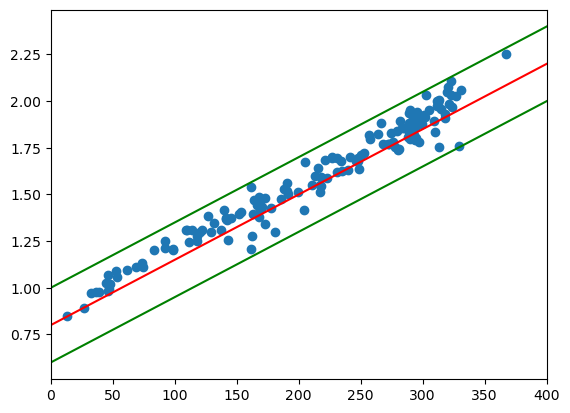

In [3]:
plt.figure()
plt.scatter(kdst.X, kdst.Y);

plt.figure()
plt.scatter(kdst.Z, kdst.Zrms)

x_line = np.linspace(0,400, 100)
y_line = 0.0035*x_line+0.8
plt.plot(x_line, y_line, color='red')
y_line = 0.0035*x_line+1
plt.plot(x_line, y_line, color='green')
y_line = 0.0035*x_line+0.6
plt.plot(x_line, y_line, color='green')
plt.xlim(0, 400)


In [4]:
# Load in the raw data
rawfile = '../data/DEMO/raw/run_12081_0001_trigger1_waveforms.h5'

file_list_raw = os.listdir("../data/DEMO/raw/")

rw_dfs = []

for file in file_list_raw:

    path = "../data/DEMO/raw/" + file

    # raw_evts = pd.read_hdf(rawfile, '/Run/events')
    raw_evts = load_dst(path, 'Run', 'events')
    # display(raw_evts)
    nrwfs = len(raw_evts.evt_number.unique())
    print("Number of Waveforms:", nrwfs)

    raw_wfs = wf_from_files([path], WfType.rwf)
    

    # Loop over waceforms and display them
    for rwf, irwf, evt_no in zip(raw_wfs, range(nrwfs), raw_evts.evt_number):
        
        evt_filter_kdst
        if evt_no in evt_filter_kdst:

            z = kdst_dfs[kdst_dfs.event == evt_no].Z.iloc[0]

            # Deconvolve the PMT Waveforms
            cwf = deconv_pmt("demopp", 12081, 35000)(rwf['pmt'])
            
            # Calibrate the deconvolved PMT Waveforms
            ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = calibrate_pmts("demopp", 12081, 100, 3)(cwf)

            times = np.array([i*25/1000 for i in range(len(np.sum(rwf['pmt'], axis=0)))])
            
            # Sum the waveforms
            sumwf = np.sum(ccwfs, axis=0)

            df = pd.DataFrame({"times" : times, "sumwf" : sumwf})
            df["z"] = z
            df["event"] = evt_no
    
            # display(df_merged)

            rw_dfs.append(df)


Number of Waveforms: 2767


KeyboardInterrupt: 

In [ ]:
rw_dfs_merge = pd.concat(rw_dfs)

# Rebin
tbw = 0.2
tbins =  np.arange(0, 1000+tbw, tbw)
tbins_centre = np.arange(0+tbw/2, 1000+tbw/2, tbw)

zbw = 50
zbins =  np.arange(0, 1000+zbw, zbw)
zbins_centre = np.arange(0+zbw/2, 1000+zbw/2, zbw)

# rw_dfs_merge['times'] = pd.cut(x=rw_dfs_merge['times'], bins=tbins,labels=tbins_centre, include_lowest=True)
rw_dfs_merge['z']     = pd.cut(x=rw_dfs_merge['z'], bins=zbins,labels=zbins_centre, include_lowest=True)

rw_dfs_merge['z'] = rw_dfs_merge['z'].astype(float)

display(rw_dfs_merge)

print(min(rw_dfs_merge.z))
print(max(rw_dfs_merge.z))


,times,sumwf,z,event
0,0.000,-0.134609,175.0,8314
1,0.025,0.606401,175.0,8314
2,0.050,-0.024226,175.0,8314
3,0.075,0.765503,175.0,8314
4,0.100,-0.238539,175.0,8314
...,...,...,...,...
39995,999.875,-0.209597,275.0,13772
39996,999.900,0.264819,275.0,13772
39997,999.925,-0.105704,275.0,13772
39998,999.950,0.264819,275.0,13772


25.0
425.0


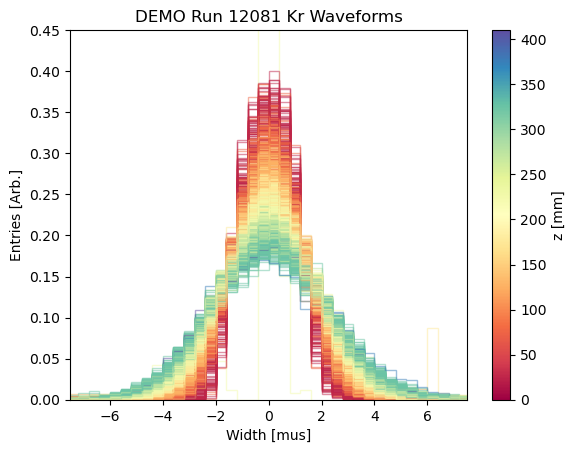

In [ ]:
# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

cmap = get_cmap('Spectral')
# cmap = get_cmap('viridis')

counter = 0
plt.figure()

rw_dfs_merge['times'] = rw_dfs_merge['times'].astype(float)
# rw_dfs_merge = rw_dfs_merge[rw_dfs_merge['times'] > 380]

event_ids = rw_dfs_merge.event.unique()

rw_dfs_merge_shifted = []

for e in event_ids: 
    # rebin 
    df = rw_dfs_merge[rw_dfs_merge.event == e]
    df_merged = df.groupby(['times', 'z'], as_index=False)['sumwf'].sum();

    # print(df_merged.z.iloc[0]/410)
    # if (df_merged.z.iloc[0] > 40):
    #     continue

    # Plot the summed waveforms
   
    # plt.plot(df_merged.times, df_merged.sumwf)
    counts, xbins = np.histogram(df_merged.times, weights = df_merged.sumwf, bins = np.linspace(395, 415, 51))

    bin_centers = xbins+ (xbins[1]-xbins[0])/2.0
    bin_centers = bin_centers[:-1]

    popt, pcov = curve_fit(Gaussian_, bin_centers, counts, bounds  = ([0 , 395, 0], [1000, 415, 20]), maxfev=50000)
    # print(popt[1])

    # plt.clf()
    plt.hist(df_merged.times-popt[1], weights = df_merged.sumwf, bins = np.linspace(-10, 10, 51), histtype = "step", color = cmap(df_merged.z.iloc[0]/410), alpha = 0.5,density=True)
    plt.ylim([0, 0.45])
    plt.xlim(-7.5,7.5)

    rw_dfs_merge_shifted.append(pd.DataFrame({"times":bin_centers-popt[1], "sumwf" :  counts, "z": df_merged.z.iloc[0]}))

sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=0, vmax=410))

# Add a color bar
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('z [mm]')
plt.xlabel("Width [mus]")
plt.ylabel("Entries [Arb.]")
plt.title("DEMO Run 12081 Kr Waveforms")

rw_dfs_merge_shifted = pd.concat(rw_dfs_merge_shifted)

# plt.show()

# if counter == 40:
#     break

counter+=1

,times,sumwf,z
0,-9.0,-1.473070,175.0
1,-8.6,-3.370688,175.0
2,-8.2,-2.188481,175.0
3,-7.8,-2.130318,175.0
4,-7.4,-2.654113,175.0
...,...,...,...
45,8.2,0.574202,275.0
46,8.6,2.068877,275.0
47,9.0,-0.231006,275.0
48,9.4,0.534655,275.0


[175. 125. 225. 325. 275.  75. 375.  25. 425.]
175.0
125.0
225.0
325.0
275.0
75.0
375.0
25.0
425.0


(-7.5, 7.5)

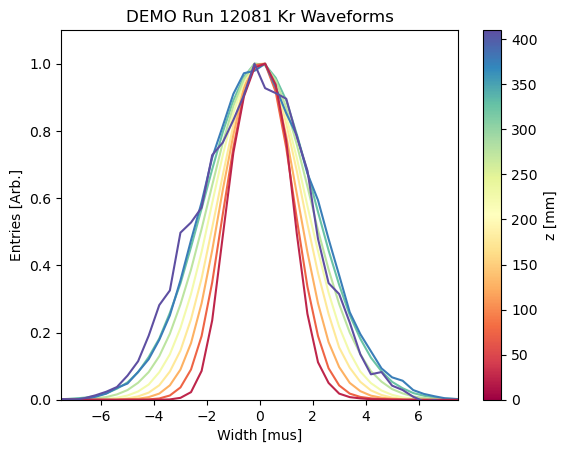

In [ ]:
# Try to get the average waveforms
# Rebin
tbw = 0.4
tbins =  np.arange(-10, 10+tbw, tbw)
tbins_centre = np.arange(-10+tbw/2, 10+tbw/2, tbw)
rw_dfs_merge_shifted['times']     = pd.cut(x=rw_dfs_merge_shifted['times'], bins=tbins,labels=tbins_centre, include_lowest=True)
display(rw_dfs_merge_shifted)

zees = rw_dfs_merge_shifted.z.unique()
print(zees)



plt.figure()

for z in zees:
    print(z)
    temp_df = rw_dfs_merge_shifted[rw_dfs_merge_shifted.z == z]
    

    average = temp_df.groupby(['times', "z"], as_index=False)['sumwf'].mean();
    average.sumwf = average.sumwf.fillna(0)
    maxval = temp_df.sumwf.sum()
    # display(average)
    average.sumwf = average.sumwf/max(average.sumwf)
    # display(average)
    # # plt.ylim([0, 0.45])
    # # plt.xlim(-7.5,7.5)

    # # plt.plot(average.times, average.sumwf)
    plt.plot(average.times,  average.sumwf, color = cmap(z/410))

sm = plt.cm.ScalarMappable(cmap='Spectral', norm=plt.Normalize(vmin=0, vmax=410))

# Add a color bar
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('z [mm]')
plt.xlabel("Width [mus]")
plt.ylabel("Entries [Arb.]")
plt.title("DEMO Run 12081 Kr Waveforms")
plt.ylim([0, 1.1])
plt.xlim(-7.5,7.5)



# Lets look at only S2 

In [68]:
file_list = os.listdir("../data/DEMO/kdst/")

evt_filter_kdst = []
kdst_dfs = []

for file in file_list:

    path = "../data/DEMO/kdst/" + file
    kdst = pd.read_hdf(path, "/DST/Events")
    kdst = kdst[kdst.nS1 == 1]
    kdst = kdst[kdst.nS2 == 1]
    # kdst = kdst[kdst.Z < 25]
    kdst = kdst[  np.sqrt(kdst.X*kdst.X + kdst.Y*kdst.Y) < 60]

    # This removes events where the zrms is not consistent with the z value
    kdst = kdst[ (kdst.Zrms > 0.0035*kdst.Z+0.6) & (kdst.Zrms < 0.0035*kdst.Z+1)  ]

    # display(kdst)

    evt_filter_kdst.append(kdst.event.unique())
    kdst_dfs.append(kdst)

evt_filter_kdst = np.concatenate(evt_filter_kdst, axis=0)
kdst_dfs = pd.concat(kdst_dfs)
print(evt_filter_kdst[12:20])
pd.set_option('display.max_columns', None)
display(kdst_dfs)

[8492 8504 8510 8550 8565 8583 8634 8645]


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,qmax,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
69,8314,1.686317e+09,0,0,1,1,125.0,1.345299,5.819739,229525.0,8.450,2071.509521,8253.557617,1530.986328,404476.34375,121.996368,86,174.951355,174.951355,1.491537,-18.739323,7.670549,20.248446,2.753070,20.899015,23.056147
124,8326,1.686317e+09,0,0,1,1,150.0,1.643902,7.698569,254775.0,8.025,2115.832520,7669.797363,1265.270386,403488.90625,102.027924,65,148.713913,148.713913,1.376443,46.224703,23.631799,51.915172,0.472597,24.204749,18.702169
173,8351,1.686317e+09,0,0,1,1,125.0,1.354941,5.873026,158750.0,9.500,1769.863281,7628.633301,1338.898804,404489.71875,119.073830,65,245.739731,245.739731,1.665869,25.533415,42.424686,49.515748,1.029016,18.606528,21.173653
212,8365,1.686317e+09,0,0,1,1,125.0,2.735059,8.831255,230725.0,8.200,2003.778809,8142.487793,1426.663940,404463.21875,114.354942,78,173.738220,173.738220,1.485563,14.434207,0.879190,14.460958,0.060835,21.548278,20.697165
218,8369,1.686317e+09,0,0,1,1,175.0,2.373553,10.791920,266750.0,7.975,2089.735840,8336.919922,1395.479736,403489.93750,129.730652,79,136.739944,136.739944,1.405988,-20.778597,-19.644295,28.594553,-2.384248,20.958342,20.787122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7223,19313,1.686318e+09,0,0,1,1,175.0,1.561092,9.493186,106450.0,10.425,1674.994385,8348.276367,1479.443481,404481.12500,111.629799,81,298.031128,298.031128,1.880435,10.253619,3.800023,10.935121,0.354910,20.828019,20.615298
7236,19316,1.686318e+09,0,0,1,1,150.0,1.798229,7.713978,103475.0,10.450,1584.807617,8053.145996,1416.571533,404500.87500,114.005318,77,301.025879,301.025879,1.923363,33.003075,7.972845,33.952455,0.237037,24.692810,20.735372
7307,19338,1.686318e+09,0,0,1,1,175.0,1.321501,6.727635,234975.0,8.125,2109.599365,8552.726562,1238.671997,403509.53125,112.142738,84,168.534546,168.534546,1.463420,-4.835905,-19.919976,20.498571,-1.808956,24.177238,27.269983
7314,19341,1.686318e+09,0,0,1,1,175.0,2.179503,8.944860,140825.0,10.275,1634.672363,7933.714844,1127.130615,404491.09375,100.798988,61,263.666107,263.666107,1.823012,45.462923,-10.302102,46.615563,-0.222841,17.282948,19.870911


Series([], Name: event, dtype: int32)


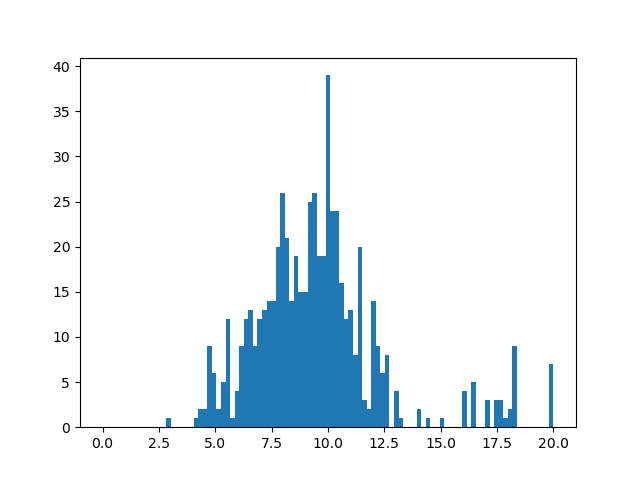

In [61]:
plt.figure()
plt.hist(kdst.S2w, bins = np.linspace(0,20,100));

print(kdst[ (kdst.S2w<4) & (kdst.S2w>3) ].event)

In [148]:
file_list_raw = os.listdir("../data/DEMO/raw/")

rw_dfs = []

evt_filter_kdst = [8369]

break_loop = False

for file in file_list_raw:

    path = "../data/DEMO/raw/" + file

    # raw_evts = pd.read_hdf(rawfile, '/Run/events')
    raw_evts = load_dst(path, 'Run', 'events')
    # display(raw_evts)
    nrwfs = len(raw_evts.evt_number.unique())
    print("Number of Waveforms:", nrwfs)

    raw_wfs = wf_from_files([path], WfType.rwf)
    

    # Loop over waceforms and display them
    for rwf, irwf, evt_no in zip(raw_wfs, range(nrwfs), raw_evts.evt_number):
        
        if evt_no in evt_filter_kdst:

            z = kdst_dfs[kdst_dfs.event == evt_no].Z.iloc[0]

            # Deconvolve the PMT Waveforms
            cwf = deconv_pmt("demopp", 12081, 35000)(rwf['pmt'])
            
            # Calibrate the deconvolved PMT Waveforms
            ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = calibrate_pmts("demopp", 12081, 100, 3)(cwf)

            times = np.array([i*25/1000 for i in range(len(np.sum(rwf['pmt'], axis=0)))])
            
            # Sum the waveforms
            sumwf = np.sum(ccwfs, axis=0)

            df = pd.DataFrame({"times" : times, "sumwf" : sumwf})
            df["z"] = z
            df["event"] = evt_no

            df = df[df.times>350]
    
            # display(df_merged)

            rw_dfs.append(df)

            break_loop = True
            break
            
        
    if(break_loop):
        break



Number of Waveforms: 2767


,event_id,sensor_id,time_bin,charge,sensor_name,x,y,z
103206,130,3,0.000,1,PmtR11410,-28.471565,-63.948181,436.549988
103207,130,3,0.150,1,PmtR11410,-28.471565,-63.948181,436.549988
103208,130,3,132.400,1,PmtR11410,-28.471565,-63.948181,436.549988
103209,130,3,132.675,2,PmtR11410,-28.471565,-63.948181,436.549988
103210,130,3,132.750,1,PmtR11410,-28.471565,-63.948181,436.549988
...,...,...,...,...,...,...,...,...
104214,130,4,142.250,2,PmtR11410,69.616531,7.316992,436.549988
104215,130,4,142.275,1,PmtR11410,69.616531,7.316992,436.549988
104216,130,4,142.300,3,PmtR11410,69.616531,7.316992,436.549988
104217,130,4,142.775,1,PmtR11410,69.616531,7.316992,436.549988


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_18971/3179005748.py:28: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(bin_centers, hist, yerr=np.sqrt(hist), fmt='o', color='black', zorder=5, label="DEMO Data", markersize=5)


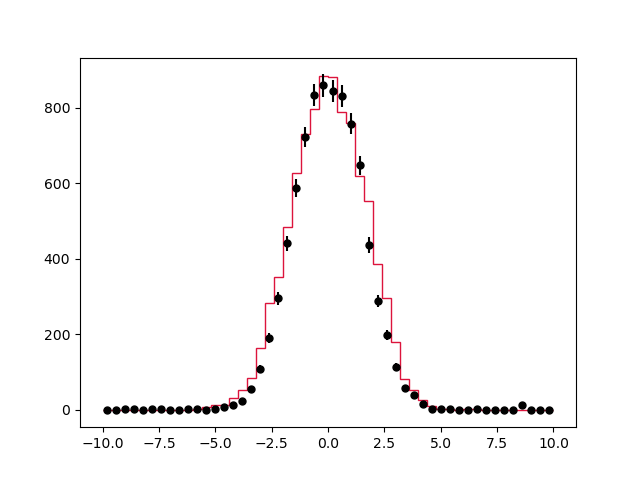

In [244]:

# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

rw_dfs_merge = pd.concat(rw_dfs)
# display(rw_dfs_merge)

# Load in the nexus generated
nexus = pd.read_hdf("/Users/mistryk2/Packages/GarfieldNexus/nexus/DEMOpp_waveform_simple.h5", "waveform")
nexusgarf = pd.read_hdf("../data/DEMO/nexus/DEMOpp_Kr_garfnexus_merged.h5", "waveforms")
z = 130
nexusgarf = nexusgarf[nexusgarf.event_id == z]

display(nexusgarf)


%matplotlib widget
# fig  = plt.figure(figsize=(10, 10))
with plt.ioff():
    fig, axis = plt.subplots()

hist, bins = np.histogram(rw_dfs_merge.times-404.476+0.7, weights = rw_dfs_merge.sumwf,bins = np.linspace(-10,10,51));
# Calculate bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Plot markers at bin centers
# plt.scatter(bin_centers, hist, marker='o', color='black', zorder=5, label="DEMO Data")
plt.errorbar(bin_centers, hist, yerr=np.sqrt(hist), fmt='o', color='black', zorder=5, label="DEMO Data", markersize=5)

popt, pcov = curve_fit(Gaussian_, bin_centers, hist, bounds  = ([0 , -10, 0], [1000, 10, 20]), maxfev=50000)
# plt.plot(np.linspace(min(bin_centers), max(bin_centers), 100), Gaussian_(np.linspace(min(bin_centers), max(bin_centers), 100), *popt), 'k-',label='fit: A = %5.0f, mu=%5.1f, sigma=%5.1f' % tuple(popt))

counts, bins, _ = plt.hist(nexusgarf.time_bin-z/.958625-5/2.2, weights = nexusgarf.charge, histtype = "step", bins = np.linspace(-10,10,51), label="GARFNEXUS 13mm", color = "crimson")
# popt, pcov = curve_fit(Gaussian_, bin_centers, counts, bounds  = ([0 , -10, 0], [1000, 10, 20]), maxfev=50000)
# plt.plot(np.linspace(min(bin_centers), max(bin_centers), 100), Gaussian_(np.linspace(min(bin_centers), max(bin_centers), 100), *popt), 'b-',label='fit: A = %5.0f, mu=%5.1f, sigma=%5.1f' % tuple(popt))

# counts, bins, _ = plt.hist(nexus.time-137.50001, weights = nexus.charge, histtype = "step", bins = np.linspace(-10,10,51), label="NEXUS 13mm", color = "darkgreen")
# popt, pcov = curve_fit(Gaussian_, bin_centers, counts, bounds  = ([0 , -10, 0], [1000, 10, 20]), maxfev=50000)
# plt.plot(np.linspace(min(bin_centers), max(bin_centers), 100), Gaussian_(np.linspace(min(bin_centers), max(bin_centers), 100), *popt), 'b-',label='fit: A = %5.0f, mu=%5.1f, sigma=%5.1f' % tuple(popt))




# plt.ylim([0, 0.45])
# plt.xlim(395,415)

disconnect_zoom = zoom_factory(axis)
# Enable scrolling and panning with the help of MPL
# Interactions library function like panhandler.
pan_handler = panhandler(fig)
display(fig.canvas)

plt.title("Z drift = 13 cm")
plt.xlabel("Time [mus]")
plt.ylabel("Charge [pes]")
plt.legend()
# plt.axvline(x=0, color='black', linestyle='--')

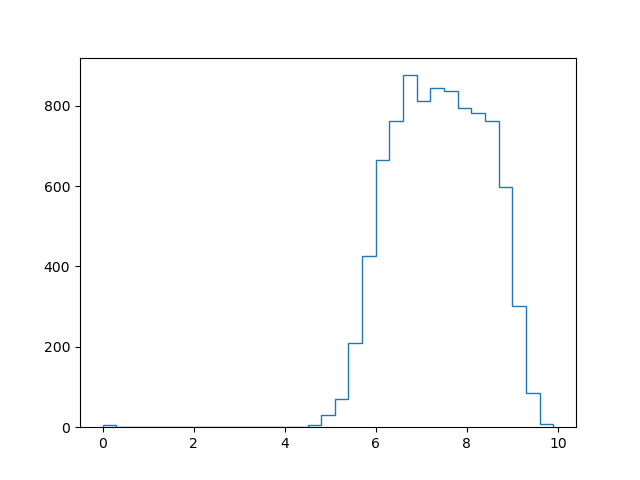

In [241]:
nexusgarf = pd.read_hdf("../data/DEMO/nexus/DEMOpp_Kr_garfnexus_merged.h5", "waveforms")
nexusgarf = nexusgarf[nexusgarf.event_id == 5]
# nexusgarf = nexusgarf[nexusgarf.time_bin > 50]

plt.figure()
plt.hist(nexusgarf.time_bin,weights = nexusgarf.charge, bins = np.arange(0, max(nexusgarf.time_bin), 0.3), histtype = "step");